In [97]:
import pickle
from transformers import BertTokenizer
import gc
import numpy as np
import torch
from collections import Counter, defaultdict, namedtuple
from functools import partial
import matplotlib.pyplot as plt

In [2]:
examples = None
with open("dev_parse.pickle", 'rb') as file:
    examples = pickle.load(file)

In [3]:
counts = Counter()
for example in examples:
    for label in example['labels']:
        counts[label] += 1

In [4]:
faulty_example = None
for i in range(len(examples)):
    try:
        assert examples[i]["attention_map"].shape[-1]-2 == len(examples[i]['words'])
    except:
        faulty_example = examples[i]

In [5]:
assert faulty_example is None

In [6]:
NUM_LAYERS,NUM_HEADS,_,_ = examples[0]['attention_map'].shape

In [95]:
CLS_TOKEN, SEP_TOKEN = ("[CLS]", "[SEP]")

In [7]:
def predict(example,layer,head,mode = "normal"):
    '''This function takes in an example (examples[i]) and uses the attention map of that example to 
    predict the head of each word in the example. The output is of same length as of example['words'] -2. -2 because predictor doesn't predict
    heads for [CLS] and [SEP] token
    
    layer -> layer in attention map to be used to predict
    head -> attention head in the the layer to predict heads
    mode -> if mode is 'normal' the head of word i is deemed to be the word j if j is the word `to` which i pays most attention i.e argmax(attn[layer][head][i]). In other words dependent is
            paying the most attention to it's head.
            if mode is 'transpose' the head of word i deemed to be the word j if j is the word `from` which i gets the most attention i.e argmax(attn[layer][head][:][i]) or argmax(attn.T[layer][head][i]).
            In other words, head is paying the most attention to dependent.
    '''
    
    attn = example['attention_map'][layer][head]
    
    if mode == "transpose": attn = attn.T
    attn[range(attn.shape[0]), range(attn.shape[0])] = 0 #ignoring the attention to self by setting diagonal elements to 0.
    
    attn = attn[1:-1, 1:-1] #ignoring attention from and to [CLS] and [SEP] token
    return np.argmax(attn, axis = -1) + 1 #because 0 prediction would mean the head is ROOT

In [56]:
def evaluate_predictor(examples, predictor):
    '''Takes in a bunch of examples and calculates the head prediction accuracy of each word in each examples and averages them up
    Additionally, also calculates the accuracy of each type of relation between words'''
    
    num_correct, num_incorrect = Counter(), Counter()
    all_labels = ['all']
    for example in examples:
        words = example['words']
        labels = example['labels']
        heads = example['heads']
         
        predictions = predictor(example)
        
        assert len(predictions) == len(labels)
        
        for i, (prediction, label, head) in enumerate(zip(predictions, labels, heads)):
            if label != 'root' and label != 'punct':
                all_labels.append(label)
                if prediction == head:
                    num_correct[label] += 1
                    num_correct['all'] += 1

                else:
                    num_incorrect[label] += 1
                    num_incorrect['all'] += 1 
                
    return {label: num_correct[label]/ float(num_correct[label] + num_incorrect[label]) for label in all_labels}
            
        

In [57]:
def get_scores(dataset, mode = "normal"):
    scores = defaultdict(dict)
    global NUM_LAYERS, NUM_HEADS
    for layer in range(NUM_LAYERS):
        for head in range(NUM_HEADS):
            scores[layer][head] = evaluate_predictor(dataset, predictor = partial(predict, layer = layer, head = head, mode = mode))
    return scores

In [58]:
scores_dictionary = {
    "dep->head": get_scores(examples, mode = "normal"),
    "head->dep": get_scores(examples, mode = "transpose")
}

In [59]:
def get_relation_stats(scores_dictionary):
    global counts
    stats = namedtuple('Stats', field_names = ['accuracy', 'layer', 'head', 'mode'])
    relation_stats = {label:stats(0,0,0,None) for label in scores_dictionary['dep->head'][0][0].keys()}
    
    for mode,scores in scores_dictionary.items():
        for layer in range(NUM_LAYERS):
            for head in range(NUM_HEADS):
                for label in relation_stats.keys():
                    if scores[layer][head][label] >= relation_stats[label].accuracy:
                        relation_stats[label] = stats(scores[layer][head][label], layer, head, mode)
                        
    return relation_stats

In [77]:
relation_stats = get_relation_stats(scores_dictionary)

In [78]:
print("{:15s} | accuracy: {:.2f} | layer{:}-head{:} | direction: {}".format("all", 100*relation_stats['all'].accuracy, relation_stats['all'].layer, relation_stats['all'].head, relation_stats['all'].mode))
relation_stats.pop("all")
for relation, stats in relation_stats.items():
    print("{:15s} | accuracy: {:.2f} | layer{:}-head{:} | direction: {}".format(relation, stats.accuracy, stats.layer, stats.head, stats.mode))

    

all             | accuracy: 43.41 | layer6-head4 | direction: dep->head
amod            | accuracy: 0.76 | layer5-head4 | direction: dep->head
nsubj           | accuracy: 0.59 | layer8-head9 | direction: dep->head
case            | accuracy: 0.76 | layer6-head4 | direction: dep->head
det             | accuracy: 0.94 | layer6-head4 | direction: dep->head
compound        | accuracy: 0.72 | layer6-head10 | direction: dep->head
nmod            | accuracy: 0.25 | layer7-head8 | direction: dep->head
cc              | accuracy: 0.48 | layer6-head5 | direction: dep->head
conj            | accuracy: 0.46 | layer11-head11 | direction: head->dep
dobj            | accuracy: 0.82 | layer5-head7 | direction: dep->head
aux             | accuracy: 0.74 | layer6-head8 | direction: dep->head
acl:relcl       | accuracy: 0.38 | layer8-head6 | direction: dep->head
advmod          | accuracy: 0.53 | layer5-head6 | direction: dep->head
ccomp           | accuracy: 0.41 | layer7-head6 | direction: dep->head
xc

In [203]:
def plot_attn(example, relation_stats, relation):
#     assert len(layers) == len(heads)
    xoffset = 1
    seperation = 4
    width = 2
    yoffset = 1
    pad = 0.1
    word_height = 1
    
    words = [CLS_TOKEN] + example['words'] + [SEP_TOKEN] 
    
    layer = relation_stats[relation].layer
    head = relation_stats[relation].head
    mode = relation_stats[relation].mode
    attn = example['attention_map'][layer][head]
    
    labels = [-1] + example['labels'] + [-1]
    
    if mode == 'head->dep':
        attn = attn.transpose(0,1)
        
    max_attn = torch.argmax(attn, dim = -1)
    
    for pos,word in enumerate(words):
        plt.text(xoffset, yoffset - pos*word_height, word, ha = "right", va = "center", fontsize = 15)
        plt.text(xoffset + width, yoffset - pos*word_height, word, ha = "left", va = "center", fontsize = 15)

        for i in range(len(words)):
            if labels[i] == relation:
                plt.plot([xoffset + pad, xoffset + width - pad],
                         [yoffset - word_height * i, yoffset - word_height * max_attn[i]],
                         color="red", linewidth=0.5, alpha = float(attn[i][max_attn[i]]))
                
            else:
                plt.plot([xoffset + pad, xoffset + width - pad],
                         [yoffset - word_height * i, yoffset - word_height * max_attn[i]],
                         color="blue", linewidth=0.5, alpha = float(attn[i][max_attn[i]])/5.0)
     
    plt.title(f'relation:{relation}, {mode}',fontsize = 20)
                
                

                

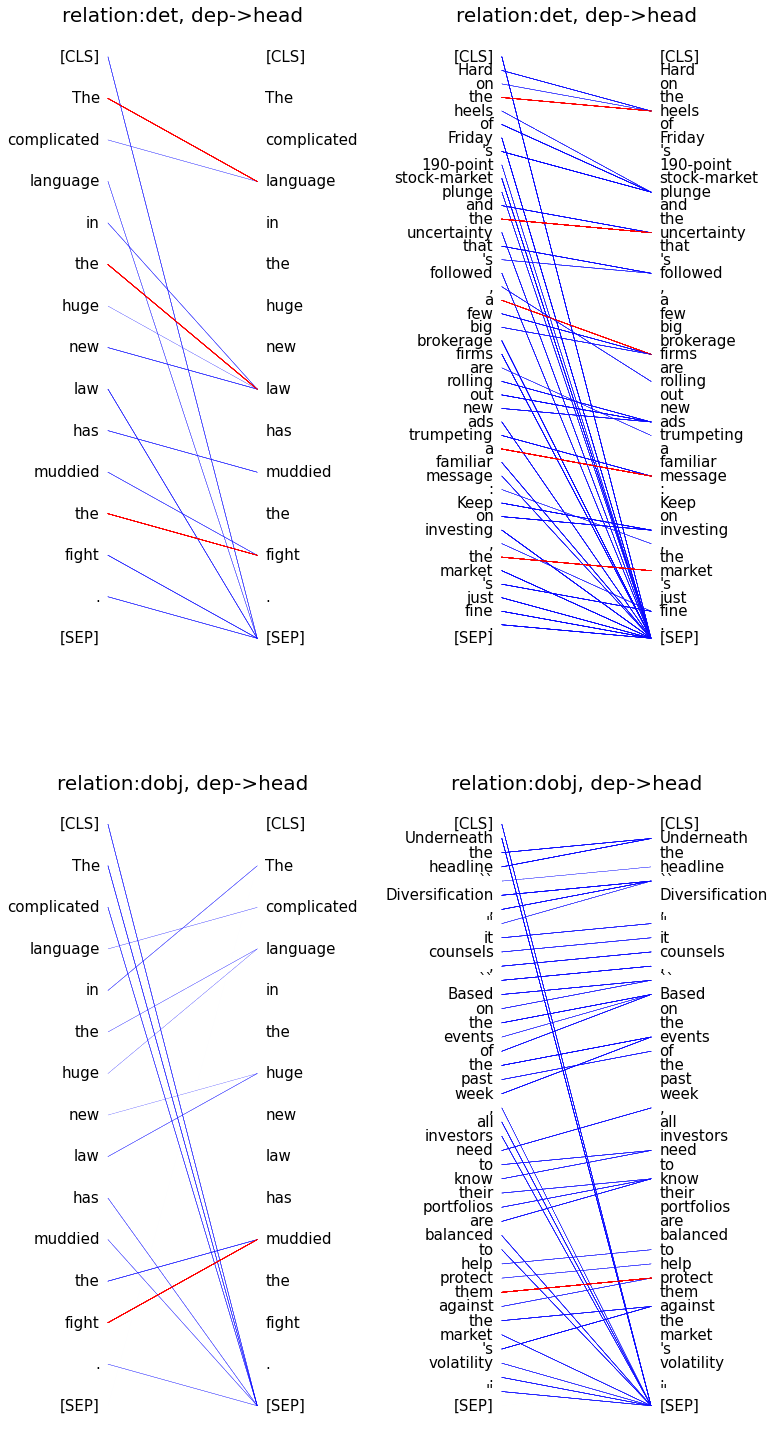

In [211]:
plt.figure(figsize = (10,40))
plt.subplot(3,3,1)
plot_attn(examples[13], relation_stats, relation = 'det')
plt.axis('off')

plt.subplot(3,3,3)
plot_attn(examples[21], relation_stats, relation = 'det')                
plt.axis("off")

plt.subplot(3,3,4)
plot_attn(examples[13], relation_stats, relation = 'dobj')                
plt.axis("off")

plt.subplot(3,3,6)
plot_attn(examples[41], relation_stats, relation = 'dobj')                
plt.axis("off")



plt.show()